In [35]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [64]:
# We are interested in the proportion of regions of state space which have been visited only once
# b is the number of subdivisions of one axis
def PNewState(X, b, cutoff):
    ranges = np.ptp(X, axis=0) + 1e-5
    Xnormalized = (X - np.min(X,axis=0)) / ranges # now all values are between 0 and 1
    countedIndices = (Xnormalized[:cutoff] * b).astype(int) # now each row should correspond to the correct index
   
    counts = np.zeros(tuple([int(b)] * X.shape[1]))
    for i in range(countedIndices.shape[0]):
        counts[tuple(countedIndices[i])] += 1
    
    return np.sum(np.logical_not(counts-1)) / cutoff # my oh my I am such a clever little fellow
    

In [67]:
# testing
X = np.array([[1,0],[1,2],[3,1]])

print(tuple([3]*3))
print(PNewState(X, 1, X.shape[0]))

(3, 3, 3)
0.0


In [114]:
def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma(t) * (y - x), x * (rho(t) - z) - y, x * y - beta(t) * z  # Derivatives

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

In [141]:
settlingTime = 5

end = 2**6
tlen = 2 ** 14 + settlingTime
reduction = 2 ** 4
# end = 2**8
# tlen = 2 ** 8 + settlingTime
trainToTest = 0.8 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.5])
# t0 = np.ones(dim) * 0.3333# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9])
t0 = np.array([4,12,17])
# t0 = np.ones(5)
# t0[0] += 0.1

In [146]:
"""
t0 = np.array([4,12,17])
Xr = odeint(Lorenz,t0,t)[::reduction]
X = Xr
"""

rho = lambda t : 28 + 20 * t / end# + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) #np.sin(np.sqrt(2)/3*2*np.pi*t/tlen) + 4*np.sin(1.687/7*2*np.pi*t/tlen)  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10 # + 10 * t / end # np.take(driverArray,t)# + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

"""
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
"""
Xr = standardize(odeint(LorenzP, t0, t, args=(rho, sigma, beta))[::reduction,0,None])
# Xr = standardize(states[:,1,None])
X, _ = delayEmbed(Xr, Xr, [10], 1)

digiDrivers = [rho]

NameError: name 'gtsr' is not defined

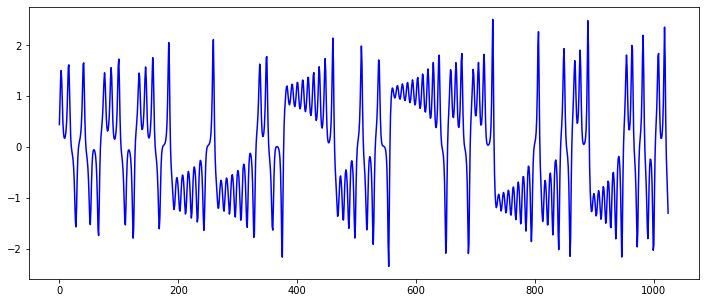

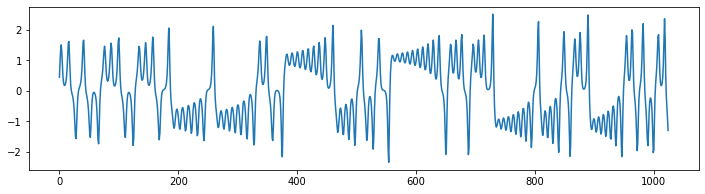

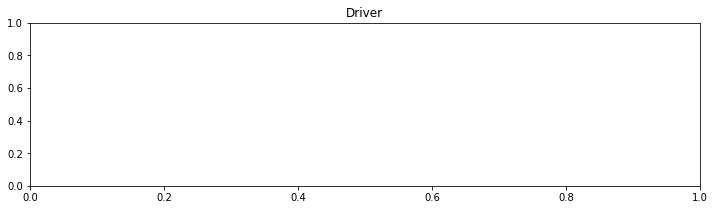

In [147]:
fig2 = plt.figure(2,figsize=(12,5))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
 
"""
embst = 3
ax2 = fig2.gca(projection="3d")
# ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.plot(Xr[:-2*embst,0],Xr[1*embst:-1*embst,0],Xr[2*embst:,0])
# ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Density Dependent Maturation")
plt.savefig("Raw Data")

figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])
else:
    axTS.plot(Xr[:])
        
plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [148]:
b = 5

PNewStateArray = np.zeros((X.shape[0],1))
for i in range(1,PNewStateArray.shape[0]):
    PNewStateArray[i] = PNewState(X, b, i)

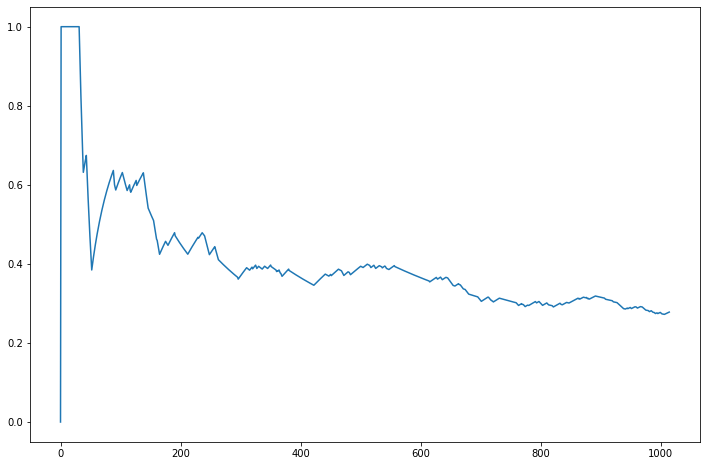

In [149]:
figPNewState, axPNewState = plt.subplots(1, figsize = (12,8))
axPNewState.plot(PNewStateArray)
plt.show()